#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [ ]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

import os
import glob
import numpy as np

#### <b>논문의 핵심 아이디어 구현 ① Instance Normalization을 위한 평균과 표준편차 계산</b>

* Instance Normalization을 구하기 위해 <b>각 이미지의 매 채널에 대하여 평균(mean)과 표준편차(std) 값을 계산</b>합니다.
* <b>Feature Map의 형태</b>: (N: 배치 크기, C: 채널 크기, H: 높이, W: 너비)
* 입실론(epsilon)은 0으로 나누는 것을 예방하기 위한 작은 상수입니다.

In [ ]:
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

#### <b>논문의 핵심 아이디어 구현 ② Adaptive Instance Normalization</b>

* 본 논문에서 제시한 AdaIN을 구현합니다.
* <b>AdaIN</b>은 content feature의 스타일을 style feature의 스타일로 변경하는 연산으로 이해할 수 있습니다.

In [ ]:
def adain(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

#### <b>인코더 및 디코더 네트워크</b>

* <b>인코더(Encoder)</b>: VGG 형식의 네트워크를 사용하여 이미지로부터 특징(feature)을 추출(extract)합니다.
* <b>디코더(Decoder)</b>: 인코더와 유사한 네트워크이지만 <b>반대로 해상도(너비 X 높이)를 키우는 방식으로 동작</b>합니다.

#### <b>인코더(Encoder)</b>

* VGG 네트워크에서 맥스 풀링(max pooling)을 총 4번 진행하지만, Style Transfer에서는 ReLU4_1까지만 사용합니다.

In [ ]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    # pooling
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    # pooling
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    # pooling
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    # pooling
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

#### <b>디코더(Decoder)</b>

* 디코더는 인코더 네트워크를 반대로 뒤집은 것과 유사한 구조를 가집니다.

In [ ]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

#### <b>사전 학습된(Pre-trained) 모델 불러오기</b> 

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2023-03-30 12:11:04--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2023-03-30 12:11:05--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  7.16MB/s    in 1.9s    



In [ ]:
# pre-trained 된 모델을 불러와서 모델 초기화

decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

# 학습된 weight로 초기화화
decoder.load_state_dict(torch.load(decoder_path)) 
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

#### <b>실습용 이미지 준비</b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/개인별 실습/영현 - V.A.R.
!unzip new_album_image.zip

/content/drive/MyDrive/개인별 실습/영현 - V.A.R.
unzip:  cannot find or open new_album_image.zip, new_album_image.zip.zip or new_album_image.zip.ZIP.


In [ ]:
class_list = os.listdir("/content/drive/MyDrive/개인별 실습/영현 - V.A.R./AdaIN/new_album_image")
class_list

['folk', 'rock', 'rap', 'electro', 'disco']

In [ ]:
path_dict = {}

for key in class_list:
    path_dict[key] = sorted(glob.glob('/content/drive/MyDrive/개인별 실습/영현 - V.A.R./AdaIN/new_album_image/{}/*.jpg'.format(key)))

for key in path_dict:
    print(key, len(path_dict[key]))

folk 1188
rock 996
rap 651
electro 457
disco 922


In [ ]:
# custom dataset을 만드는 함수 정의

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_input = [f for f in lst_data]

        lst_input.sort()

        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        input = Image.open(os.path.join(self.data_dir, self.lst_input[index]))

        if self.transform:
            input = self.transform(input)

        return input

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])

# Define the dataset. rap 장르에 대한 이미지들 불러오기
dataset = Dataset(data_dir='/content/drive/MyDrive/개인별 실습/영현 - V.A.R./new_album_image/rap', transform=transform)

# Define the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
# rgb가 흑백인 사진이 존재해서 흑백인 사진의 index 확인

lst1 = []
for idx, i in enumerate(dataloader):
  if i.shape[1] != 3:
    lst1.append(idx)
lst1

[]

In [ ]:
# content 이미지 불러오기
content = Image.open('/content/drive/MyDrive/개인별 실습/영현 - V.A.R./download.jpg')
content = transform(content).to(device).unsqueeze(0)

# rap에 대한 이미지에 대해서 style 추출해서 lst2에 담기
lst2 = []
with torch.no_grad():
  for idx, style in enumerate(dataloader):
    if idx in lst1:
      continue
    style = style.to(device)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adain(content_f, style_f)
    lst2.append(feat)

# style feature interpolation
images_tensor = torch.stack([img for img in lst2], dim=0)
interpolated_feat = images_tensor.mean(dim=0)

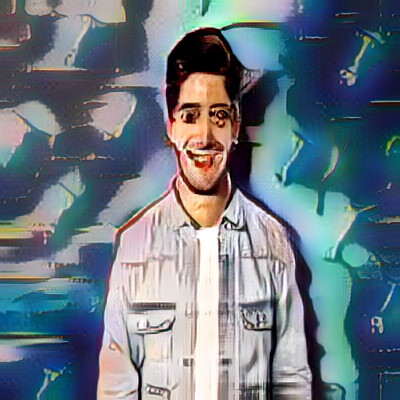

In [ ]:
# generated image
alpha = 0.8
output = decoder((1-alpha)*content_f + alpha*interpolated_feat).cpu()
save_image(output, 'output2.png')
display_image('./output2.png')

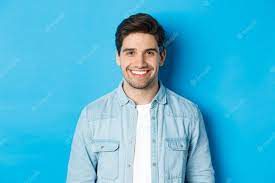

In [ ]:
# content image
Image.open('/content/drive/MyDrive/개인별 실습/영현 - V.A.R./download.jpg')